In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from functools import reduce
from pathlib import Path
import re
import logging

from scope_del.metrics import (
    tanimoto_int_similarity_matrix_numba,
    top_overlap,
    make_labels_and_scores,
    enrichment_factor,
    bedroc,
    coverage_metrics_multi_threshold
)
from scope_del.plots import plot_cdp

from tqdm import tqdm
# Configure logging
logging.basicConfig(level=logging.INFO)

# Creating combined_df

In [2]:
# File paths and prefixes
file_info = {
    '../results/dels_100/euclidean_mfp_resp_chembl301.csv' : 'euc_resp',
    '../results/dels_100/tanimoto_mfp_resp_chembl301.csv': 'tan_resp',
    '../results/dels_100/euclidean_mfp_chembl301.csv': 'euc_mfp',
    '../results/dels_100/tanimoto_mfp_chembl301.csv': 'tan_mfp'
}


In [3]:
def make_id(p):
    s = Path(p).stem
    m = re.match(r'([A-Za-z]+)0*([1-9]\d*)_(\d+)', s)
    return f'{m.group(1)}{m.group(2)}_{m.group(3)}' if m else s

In [4]:
dfs = []
group_labels = []   # number of numeric columns per group (for later grid lines)
for file_path, prefix in file_info.items():
    df = pd.read_csv(file_path)
    
    # Drop metadata columns we do not want
    drop_cols = ['computation_time', 'reference_count', 'query_count']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
    print(file_path, df.shape)
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Keep query_path plus numeric columns
    
    df['query_id'] = df['query_path'].apply(make_id)
    required_cols = ['query_id'] + numeric_cols
    df_numeric = df[required_cols].copy()
    
    # Prefix numeric column names so they remain distinct after merging
    df_numeric.rename(columns={col: f'{prefix}_{col}' for col in numeric_cols}, inplace=True)
    
    dfs.append(df_numeric)
    group_labels.append(len(numeric_cols))

# Merge all dataframes on query_path (inner join keeps only rows present in every file)


combined_df = reduce(lambda l, r: pd.merge(l, r, on='query_id', how='inner'), dfs)
combined_df.set_index('query_id', inplace=True)

combined_df['sim_tan_resp_centroid'] = 1 - combined_df['tan_resp_centroid']
combined_df['sim_tan_mean_pairwise'] = 1 - combined_df['tan_mfp_mean_pairwise']
combined_df['sim_tan_s_min'] = 1 - combined_df['tan_mfp_s_min']

../results/dels_100/euclidean_mfp_resp_chembl301.csv (100, 17)
../results/dels_100/tanimoto_mfp_resp_chembl301.csv (100, 19)
../results/dels_100/euclidean_mfp_chembl301.csv (100, 15)
../results/dels_100/tanimoto_mfp_chembl301.csv (100, 17)


# Supplementary Figure SF2

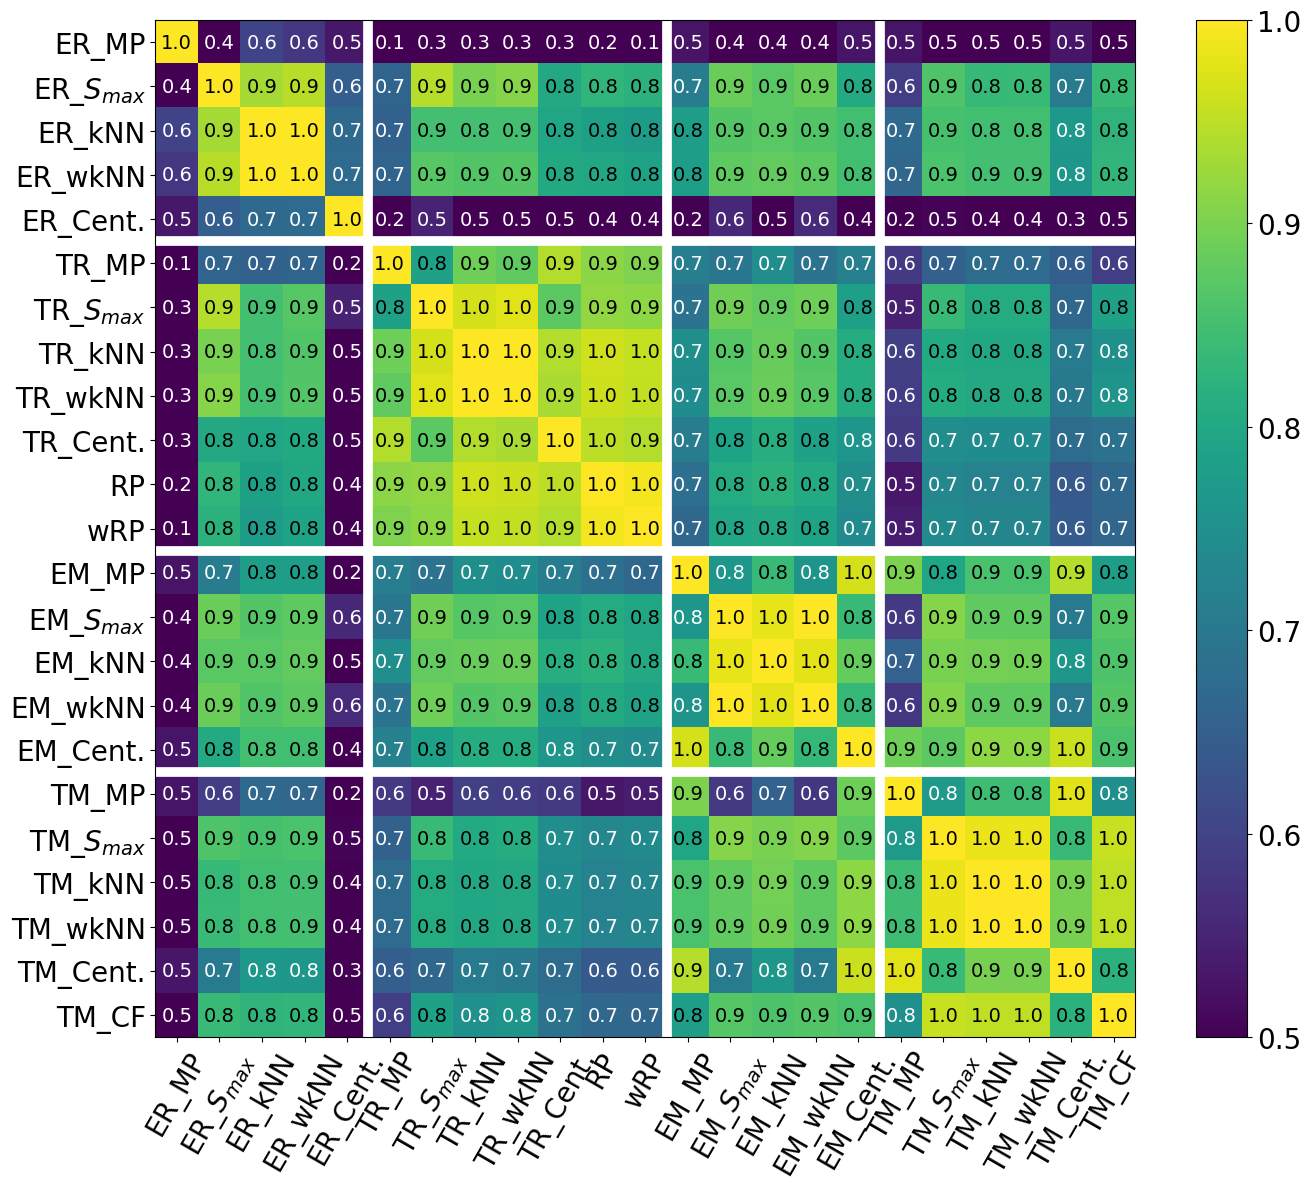

In [5]:
# Reload correlation matrix
file_path = "../data/heatmap_chembl301_short.csv"
heatmap_matrix = pd.read_csv(file_path, index_col=0)

# Abbreviation dictionary
metric_map = {
    'mean_pairwise': 'MP',
    's_min': r'$S_{max}$',
    'knn': 'kNN',
    'weighted_knn': 'wkNN',
    'centroid': 'Cent.',
    'covered_fraction': 'CF'
}

def abbreviate(name: str) -> str:
    parts = name.split('_')
    if len(parts) < 3:
        return name
    if 'RP' in name:
        prefix = ''
        metric_key = parts[2]#.replace('_', '')
        metric_abbr = metric_key
        return f"{metric_abbr}"
    else:
        prefix = ('E' if parts[0] == 'euc' else 'T') + ('R' if parts[1] == 'resp' else 'M')
        metric_key = '_'.join(parts[2:])
        metric_abbr = metric_map.get(metric_key, metric_key[:3])
        return f"{prefix}_{metric_abbr}"

# Apply abbreviations

mapping = {col: abbreviate(col) for col in heatmap_matrix.columns}
heatmap_short = heatmap_matrix.rename(columns=mapping, index=mapping).abs()

# Numeric labels
num_labels = list(range(1, len(heatmap_short.columns) + 1))

# Font sizes
axis_fontsize = 20
cbar_fontsize = 20

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
cax = ax.imshow(heatmap_short, aspect='auto', vmin=0.5, vmax=1)

ax.set_xticks(range(len(heatmap_short.columns)))
ax.set_xticklabels(heatmap_short.columns, rotation=60, fontsize=axis_fontsize)
ax.set_yticks(range(len(heatmap_short.index)))
ax.set_yticklabels(heatmap_short.index, fontsize=axis_fontsize)

# Axis tick labels (numbers)
#ax.set_xticks(range(len(num_labels)))
#ax.set_xticklabels(num_labels, rotation=90, fontsize=axis_fontsize)
#ax.set_yticks(range(len(num_labels)))
#ax.set_yticklabels(num_labels, fontsize=axis_fontsize)

# Delimiters
prefix_prev = heatmap_short.columns[0][0]
group_prev = heatmap_short.columns[0][1]

for i, label in enumerate(heatmap_short.columns[1:], start=1):
    prefix_curr, group_curr = label[0], label[1]
    if prefix_curr == 'R' or prefix_curr=='w':
        pass
    elif prefix_curr != prefix_prev:
        ax.axvline(i - 0.5, color='white', linewidth=7)
        ax.axhline(i - 0.5, color='white', linewidth=7)
    elif group_curr != group_prev:
        ax.axvline(i - 0.5, color='white', linewidth=1)
        ax.axhline(i - 0.5, color='white', linewidth=1)
    prefix_prev, group_prev = prefix_curr, group_curr

# Colorbar with larger tick labels
cbar = fig.colorbar(cax)
cbar.ax.tick_params(labelsize=cbar_fontsize)


# --- annotate heatmap cells ---
data = heatmap_short.values

# choose 1 or 2 decimals
decimals = 1                # set to 1 for one decimal place
fmt = f"{{:.{decimals}f}}"  # e.g., "{:.2f}"

# helper to keep text readable on light/dark backgrounds
def cell_text_color(v, im_obj):
    r, g, b, _ = im_obj.cmap(im_obj.norm(v))
    # perceived luminance (ITU-R BT.709)
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    return "black" if lum > 0.5 else "white"

for (i, j), v in np.ndenumerate(data):
    ax.text(
        j, i, fmt.format(v),
        ha="center", va="center",
        fontsize=14,
        color=cell_text_color(v, cax),   # keeps contrast with the colormap
        zorder=5                        # ensure text stays above grid/separator lines
    )

# Title
#plt.title('Spearman Correlation Supermatrix (Numeric Labels, Larger Fonts)', pad=20)
plt.tight_layout()
plt.savefig('../results/SF2.svg')
plt.show()

# Mapping table (redisplay for convenience)
mapping_df = pd.DataFrame({
    "Number": num_labels,
    "Short_Label": heatmap_short.columns
})


# Supplementary Figure SF1

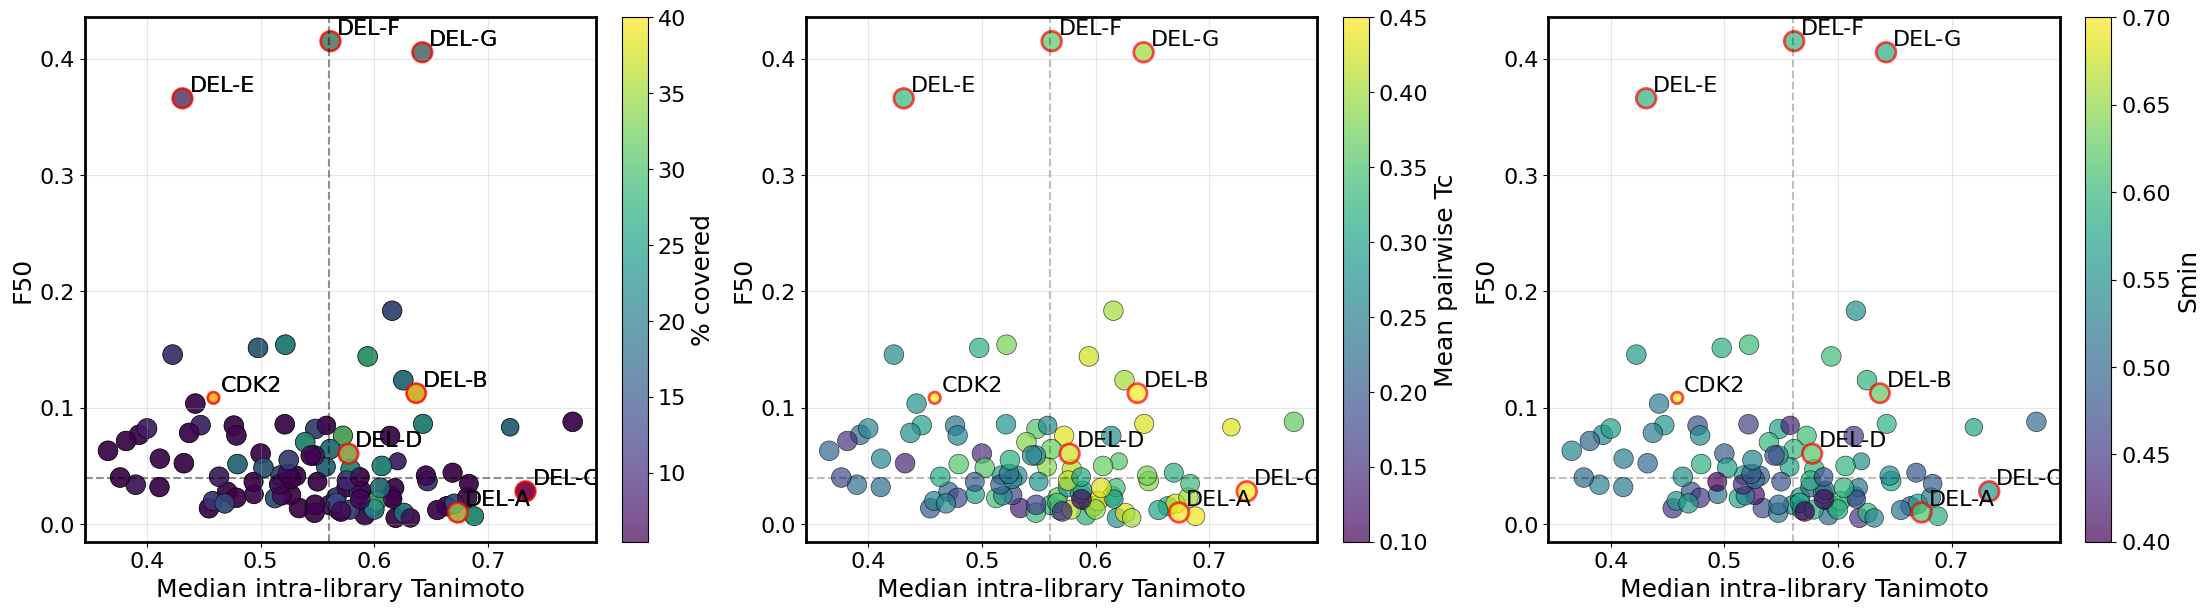

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

cdp_stats = pd.read_csv('../results/del_chembl301_cpd.csv')


custom_names = {
    'EN5723_1': 'DEL-A',
    'EN16700_1': 'DEL-B', 
    'EN11303_1': 'DEL-C',
    'EN23710_1': 'DEL-D',
    'EN1310_1': 'DEL-E',
    'EN2780_1': 'DEL-F',
    'EN18266_1': 'DEL-G',
    'CHEMBL301': 'CDK2'
}

fig, axes = plt.subplots(1, 3, figsize=(22, 6), constrained_layout=True)

plot_cdp(cdp_stats, 
         label_ids=custom_names.keys(),
        label_color='red',
         axis_linewidth=2.0,
         label_size = 18,
        tick_size = 16,
         xlabel="Median intra-library Tanimoto",
         ylabel="F50",
        colors=['black'], 
        label_names=custom_names,
         ax=axes[0],
        show=False
        )

# 1) % covered
color_values = combined_df.loc[
    cdp_stats[cdp_stats['identifier'] != 'CHEMBL301'].identifier
]['tan_mfp_covered_fraction'].to_list()
color_values.extend([1])
color_values = (pd.Series(color_values) * 100).to_list()

plot_cdp(
    cdp_stats,
    label_ids=custom_names.keys(),
    label_color='red',
    axis_linewidth=2.0,
    label_size=18,
    tick_size=16,
    xlabel="Median intra-library Tanimoto",
    ylabel="F50",
    colorbar_label='% covered',
    colors=['black'],
    label_names=custom_names,
    color_by=color_values,
    vmax=40,
    ax=axes[0],
    show=False
)

# 2) Mean pairwise Tc
color_values = combined_df.loc[
    cdp_stats[cdp_stats['identifier'] != 'CHEMBL301'].identifier
]['sim_tan_mean_pairwise'].to_list()
color_values.extend([1])

plot_cdp(
    cdp_stats,
    label_ids=custom_names.keys(),
    label_color='red',
    axis_linewidth=2.0,
    label_size=18,
    tick_size=16,
    xlabel="Median intra-library Tanimoto",
    ylabel="F50",
    colorbar_label='Mean pairwise Tc',
    colors=['black'],
    label_names=custom_names,
    color_by=color_values,
    vmax=0.45,
    vmin=0.1,
    ax=axes[1],
    show=False
)

# 3) Smin (1 - tan_mfp_s_min)
color_values = combined_df.loc[
    cdp_stats[cdp_stats['identifier'] != 'CHEMBL301'].identifier
]['tan_mfp_s_min'].to_list()
color_values.extend([0])
color_values = (1 - pd.Series(color_values)).to_list()

plot_cdp(
    cdp_stats,
    label_ids=custom_names.keys(),
    label_color='red',
    axis_linewidth=2.0,
    label_size=18,
    tick_size=16,
    xlabel="Median intra-library Tanimoto",
    ylabel="F50",
    colorbar_label='Smin',
    colors=['black'],
    label_names=custom_names,
    color_by=color_values,
    vmax=0.7,
    vmin=0.4,
    ax=axes[2],
    show=False
)

plt.savefig('../results/SF1.svg')
plt.show()


# Calculating additional scores

In [7]:
ref_features = np.load('../data/dels_100/CHEMBL301.npz')['arr_0']
ref_features = ref_features.astype(np.float64)

In [8]:
# ---------- runner over DELs ----------
thresholds = [0.30, 0.35, 0.40, 0.45, 0.50, 0.55]

all_results = []

# del_libs: your DataFrame with at least column "identifier"
# ref_features: your reference feature matrix (targets to cover)
# tanimoto_int_similarity_matrix_numba(ref_features, del_features) must return n_targets x n_lib similarities

# If your folder name is actually del_id, use that; otherwise keep 'desc' if you already have it defined.
# directory = Path(f"../data/dels_100/{desc}/")
directory = Path(f"../data/dels_100/mfp/")  # <- change back to {desc} if needed

en_files = sorted(directory.glob("EN*.npz"))


n_targets = ref_features.shape[0]

# Threshold-agnostic: running best hit per target across ALL shards (for median best similarity)
best_per_target = np.zeros(n_targets, dtype=np.float32)

# Prepare threshold-specific aggregators

for file_path in tqdm(en_files, leave=False, desc=f"shards"):
    del_features = np.load(file_path)['arr_0']  # shape: n_lib_file x ...
    del_features =  del_features.astype(np.float64)
    # n_targets x n_lib_file similarity matrix
    S = tanimoto_int_similarity_matrix_numba(ref_features, del_features)
    res = pd.DataFrame(coverage_metrics_multi_threshold(S, thresholds))
    res['DEL_ID'] = file_path.stem
    all_results.append(res)
    #res.update({
    #        "del_id": del_id,
    #        "threshold": t,
    #        "median_besthit_similarity": median_besthit_similarity,
    #    })
    #    all_results.append(res)


In [10]:
pd.concat(all_results)

,thresh_0.3,thresh_0.35,thresh_0.4,thresh_0.45,thresh_0.5,thresh_0.55,DEL_ID
n_targets,1780.00000,1780.00000,1780.000000,1780.000000,1780.000000,1780.000000,EN10412_1
n_library,9696.00000,9696.00000,9696.000000,9696.000000,9696.000000,9696.000000,EN10412_1
n_covered_targets,1.00000,44.00000,299.000000,899.000000,1446.000000,1704.000000,EN10412_1
pct_covered_targets,0.05618,2.47191,16.797753,50.505618,81.235955,95.730337,EN10412_1
n_participating_library,1.00000,47.00000,371.000000,1640.000000,4706.000000,8544.000000,EN10412_1
...,...,...,...,...,...,...,...
f1_coverage_participation,0.00000,0.00000,0.002049,0.097685,0.476223,0.820003,EN9951_1
participation_adjusted_coverage_pct,0.00000,0.00000,0.000420,0.887265,19.805380,60.875527,EN9951_1
evenness_of_participation,0.00000,0.00000,0.992991,0.928735,0.873259,0.905220,EN9951_1
effective_participating_library,0.00000,0.00000,16.665745,527.319965,1497.989503,3215.579450,EN9951_1


In [11]:
# df is the result of pd.concat(all_results)
df = pd.concat(all_results).rename_axis('metric')  # make the index name explicit

# columns like 'thresh_0.3', 'thresh_0.35', ...
thresh_cols = [c for c in df.columns if c.startswith('thresh_')]

# long form: one row per (metric, DEL_ID, threshold)
long = (df.reset_index()
          .melt(id_vars=['metric', 'DEL_ID'],
                value_vars=thresh_cols,
                var_name='threshold', value_name='value'))

# wide form: pivot by DEL_ID; rows are (metric, threshold)
out = (long.pivot_table(index=['metric', 'threshold'],
                        columns='DEL_ID', values='value', aggfunc='first')
            .sort_index())

out_flat = (out.reset_index()
               .assign(metric=lambda x: x['metric'] + '_' + x['threshold'])
               .drop(columns='threshold')
               .set_index('metric')
               .sort_index())
out_flat = out_flat.T
fin_df = combined_df.join(out_flat, how='left')

In [12]:
top_overlap(fin_df['tan_resp_RP_GTM'], fin_df['pct_covered_targets_thresh_0.35'], n_a=10, n_b=3)

(2,
 {'EN10507_1',
  'EN11510_1',
  'EN17081_1',
  'EN18889_1',
  'EN20884_1',
  'EN22605_1',
  'EN23710_1',
  'EN23821_1',
  'EN5723_1',
  'EN6061_1'},
 {'EN16700_1', 'EN23710_1', 'EN5723_1'},
 {'EN23710_1', 'EN5723_1'})

In [13]:
top_overlap(fin_df['sim_tan_resp_centroid'], fin_df['sim_tan_mean_pairwise'], n_a=10, n_b=5)

(2,
 {'EN16700_1',
  'EN17081_1',
  'EN18889_1',
  'EN19734_1',
  'EN20884_1',
  'EN23710_1',
  'EN23821_1',
  'EN25794_1',
  'EN5723_1',
  'EN6061_1'},
 {'EN11303_1', 'EN1669_1', 'EN16700_1', 'EN26950_1', 'EN5723_1'},
 {'EN16700_1', 'EN5723_1'})

In [14]:
fin_df['f1_coverage_participation_thresh_0.35']

query_id
EN10412_1    0.008105
EN10507_1    0.214555
EN10558_1    0.023065
EN10571_1    0.000170
EN10726_1    0.001113
               ...   
EN8961_1     0.000170
EN9354_1     0.000000
EN93_1       0.003697
EN9803_1     0.025461
EN9951_1     0.000000
Name: f1_coverage_participation_thresh_0.35, Length: 100, dtype: float64

In [15]:
top_overlap(fin_df['sim_tan_resp_centroid'], fin_df['sim_tan_s_min'], n_a=10, n_b=5)

(4,
 {'EN16700_1',
  'EN17081_1',
  'EN18889_1',
  'EN19734_1',
  'EN20884_1',
  'EN23710_1',
  'EN23821_1',
  'EN25794_1',
  'EN5723_1',
  'EN6061_1'},
 {'EN1669_1', 'EN16700_1', 'EN20884_1', 'EN23710_1', 'EN5723_1'},
 {'EN16700_1', 'EN20884_1', 'EN23710_1', 'EN5723_1'})

In [16]:
top_overlap(fin_df['sim_tan_resp_centroid'], fin_df['f1_coverage_participation_thresh_0.35'], n_a=5, n_b=3)

(2,
 {'EN16700_1', 'EN19734_1', 'EN23710_1', 'EN5723_1', 'EN6061_1'},
 {'EN16700_1', 'EN26950_1', 'EN5723_1'},
 {'EN16700_1', 'EN5723_1'})

In [17]:
top_overlap(fin_df['sim_tan_resp_centroid'], fin_df['pct_covered_targets_thresh_0.35'], n_a=5, n_b=3)

(3,
 {'EN16700_1', 'EN19734_1', 'EN23710_1', 'EN5723_1', 'EN6061_1'},
 {'EN16700_1', 'EN23710_1', 'EN5723_1'},
 {'EN16700_1', 'EN23710_1', 'EN5723_1'})

In [20]:
 # Turn "A top-5%" into positives; evaluate on "B"
idx, y_true, y_score = make_labels_and_scores(fin_df["sim_tan_resp_centroid"], fin_df["pct_covered_targets_thresh_0.35"], pct=0.01)

ef_at_1pct = enrichment_factor(y_true, y_score, top_pct=0.01)
ef_at_10 = enrichment_factor(y_true, y_score, top_k=10)
bedroc_20 = bedroc(y_true, y_score, alpha=20.0)

print(f"EF@1%:  {ef_at_1pct:.3f}")
print(f"EF@10:  {ef_at_10:.3f}")
print(f"BEDROC(alpha=20): {bedroc_20:.3f}")

EF@1%:  0.000
EF@10:  10.000
BEDROC(alpha=20): 0.819


In [21]:
fin_df.sort_values(["sim_tan_resp_centroid"])["sim_tan_resp_centroid"], fin_df.sort_values(["sim_tan_mean_pairwise"])["sim_tan_mean_pairwise"]

(query_id
 EN4505_1     0.000003
 EN13337_1    0.000009
 EN18290_1    0.000010
 EN3298_1     0.000011
 EN5738_1     0.000036
                ...   
 EN6061_1     0.138014
 EN19734_1    0.143481
 EN23710_1    0.146840
 EN16700_1    0.149412
 EN5723_1     0.244833
 Name: sim_tan_resp_centroid, Length: 100, dtype: float64,
 query_id
 EN4505_1     0.112901
 EN1450_1     0.126562
 EN8961_1     0.134443
 EN3298_1     0.141273
 EN15881_1    0.143096
                ...   
 EN1669_1     0.434946
 EN26950_1    0.440759
 EN11303_1    0.453394
 EN5723_1     0.466180
 EN16700_1    0.466836
 Name: sim_tan_mean_pairwise, Length: 100, dtype: float64)

In [22]:
 # Turn "A top-5%" into positives; evaluate on "B"
idx, y_true, y_score = make_labels_and_scores(fin_df["sim_tan_resp_centroid"], fin_df["sim_tan_mean_pairwise"], n=3)

ef_at_1pct = enrichment_factor(y_true, y_score, top_pct=0.01)
ef_at_10 = enrichment_factor(y_true, y_score, top_k=3)
bedroc_20 = bedroc(y_true, y_score, alpha=20.0)

print(f"EF@1%:  {ef_at_1pct:.3f}")
print(f"EF@10:  {ef_at_10:.3f}")
print(f"BEDROC(alpha=20): {bedroc_20:.3f}")

EF@1%:  33.333
EF@10:  22.222
BEDROC(alpha=20): 0.767


In [23]:
 y_true, y_score

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0.31459903, 0.42927214, 0.35351898, 0.31871466, 0.25855517,
        0.2266398 , 0.45339444, 0.41231169, 0.35483258, 0.19376309,
        0.33025032, 0.27389049, 0.29604845, 0.34205818, 0.25632418,
        0.12656228, 0.22936069, 0.31150079, 0.23727712, 0.42527844,
        0.37086322, 0.17133354, 0.14309645, 0.27091966, 0.25709232,
        0.21344629, 0.34212038, 0.38695845, 0.4286987 , 0.43494631,
        0.46683606, 0.40269678, 0.38417534, 0.28007705, 0.34049351,
        0.34403616, 0.29455181, 0.38319531, 0.39714727, 0.3649546 ,
        0.40091304, 0.42512876, 0.26842317, 0.27665572, 0.20928484,
        0.20259851, 0.38788319, 0.26296013, 0.

# Fig. 2.

In [9]:
fin_df_intra = pd.read_csv('../results/fin_df_intra.csv')

In [10]:
fin_df_intra['sim_tan_mfp_centroid'] = 1 - fin_df_intra['tan_mfp_centroid']
fin_df_intra['sim_tan_resp_centroid'] = 1 - fin_df_intra['tan_resp_centroid']
fin_df_intra['sim_tan_mean_pairwise'] = 1 - fin_df_intra['tan_mfp_mean_pairwise']
fin_df_intra['sim_tan_mfp_s_min'] = 1 - fin_df_intra['tan_mfp_s_min']
fin_df_intra['sim_resp_s_min'] = 1 - fin_df_intra['tan_resp_s_min']
fin_df_intra['sim_tan_mfp_knn'] = 1 - fin_df_intra['tan_mfp_knn']
fin_df_intra['sim_tan_mfp_weighted_knn'] = 1 - fin_df_intra['tan_mfp_weighted_knn']

In [11]:
directory = Path(f"../data/dels_100/mfp/")  # <- change back to {desc} if needed

en_files = sorted(directory.glob("EN*.npz"))

# Prepare threshold-specific aggregators
del_names = []
for file_path in tqdm(en_files, leave=False, desc=f"shards"):
    del_names.append(file_path.stem)

In [12]:
fin_df_intra.index = del_names

In [13]:
fin_df_intra

,euc_resp_mean_pairwise,euc_resp_mean_pairwise_median_threshold,euc_resp_s_min,euc_resp_knn,euc_resp_weighted_knn,euc_resp_chamfer,euc_resp_sinkhorn,euc_resp_centroid,euc_resp_MW2_GTM,euc_resp_RP_GTM,...,pct_participating_library_thresh_0.45,pct_participating_library_thresh_0.5,pct_participating_library_thresh_0.55,sim_tan_mfp_centroid,sim_tan_resp_centroid,sim_tan_mean_pairwise,sim_tan_mfp_s_min,sim_resp_s_min,sim_tan_mfp_knn,sim_tan_mfp_weighted_knn
EN10412_1,1.282693,1.055699,0.488220,0.672354,0.661055,0.764947,0.937191,0.036081,1.888136,0.029486,...,16.914191,48.535479,88.118812,0.551368,0.019035,0.314599,0.546934,0.245380,0.519174,0.519331
EN10507_1,1.305023,1.056562,0.419483,0.539051,0.528066,0.396158,0.840485,0.038962,2.057845,0.077792,...,93.008925,99.702507,100.000000,0.743375,0.101073,0.429272,0.591505,0.342725,0.576312,0.576361
EN10558_1,1.212603,0.985965,0.445848,0.604474,0.591891,0.631276,0.922288,0.024811,0.916692,0.034504,...,31.932435,66.871104,90.910919,0.647639,0.042434,0.353519,0.573218,0.340570,0.544412,0.544575
EN10571_1,1.245847,1.020974,0.591398,0.658072,0.652939,0.913972,0.941339,0.060960,1.705934,0.027604,...,11.940000,34.490000,78.770000,0.555170,0.011411,0.318715,0.499489,0.154273,0.483234,0.483292
EN10726_1,1.171646,0.943615,0.580584,0.655335,0.648083,0.858986,NaN,0.017776,0.724515,0.015684,...,6.368453,18.167923,35.214999,0.481330,0.015500,0.258555,0.525553,0.144825,0.497152,0.497308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EN8961_1,1.235423,1.010059,0.659171,0.744258,0.741045,1.140029,NaN,0.028674,0.992357,0.004391,...,0.530000,2.360000,7.060000,0.220994,0.000403,0.134443,0.504961,0.050244,0.456488,0.457020
EN9354_1,1.084603,0.874717,0.672045,0.698077,0.697708,0.909213,NaN,0.021002,1.102005,0.000627,...,0.000000,0.483247,5.133162,0.334859,0.000973,0.198787,0.377398,0.010115,0.357654,0.357746
EN93_1,1.295272,1.062147,0.492442,0.706344,0.693709,0.940687,NaN,0.028605,1.755960,0.030113,...,3.441032,13.564069,36.620986,0.496699,0.015782,0.263114,0.561553,0.270120,0.515223,0.515625
EN9803_1,1.249712,1.018046,0.404913,0.594828,0.577852,0.613020,0.901774,0.021606,1.254933,0.045169,...,32.754467,72.997390,97.550693,0.683143,0.054228,0.354186,0.591887,0.402355,0.556609,0.556877


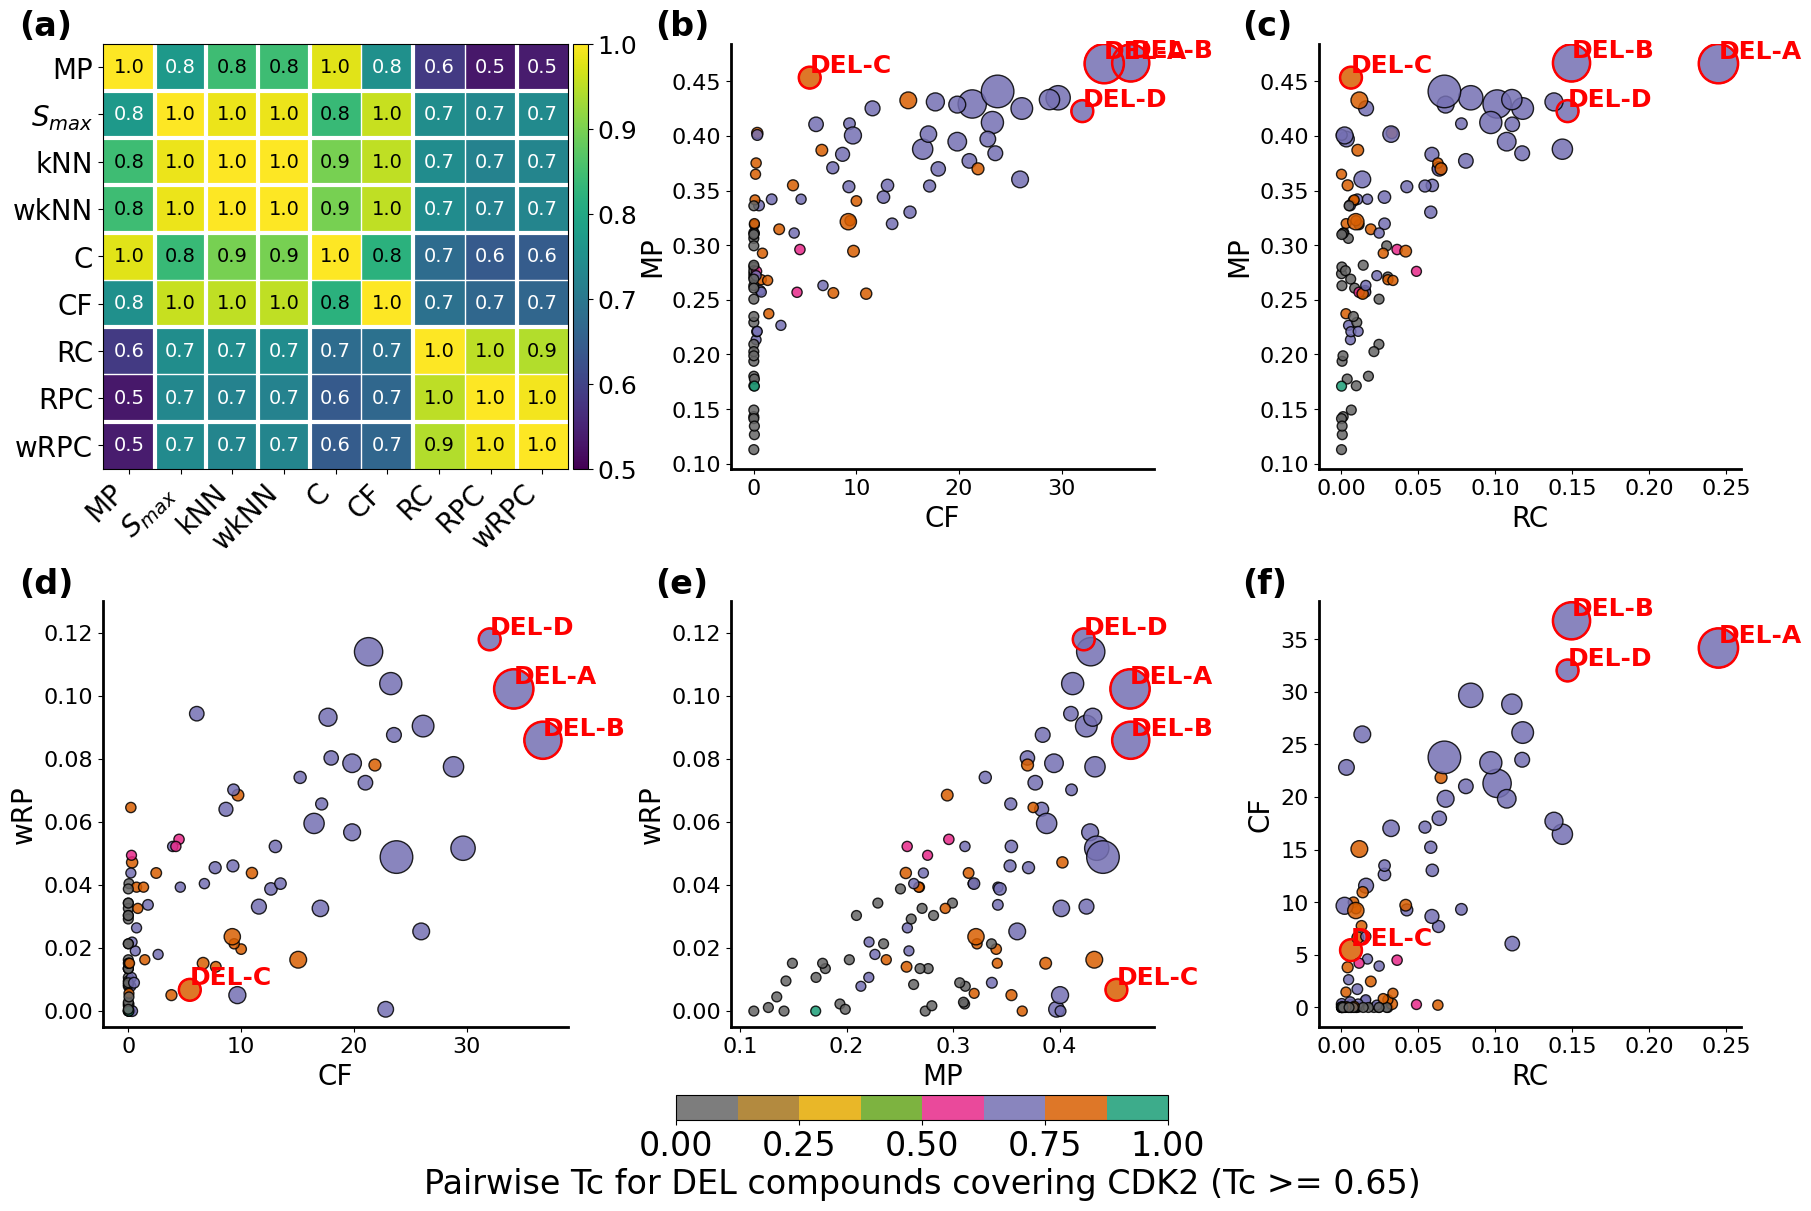

In [14]:
# ---------- load & prepare heatmap ----------
file_path = "../data/heatmap_chembl301_short.csv"
heatmap_matrix = pd.read_csv(file_path, index_col=0)

cols_select = [
    'tan_resp_mean_pairwise','tan_resp_s_min','tan_resp_knn','tan_resp_weighted_knn',
    'tan_resp_centroid','tan_resp_RP_GTM','tan_resp_wRP_GTM',
    'tan_mfp_mean_pairwise','tan_mfp_s_min','tan_mfp_knn','tan_mfp_weighted_knn',
    'tan_mfp_centroid','tan_mfp_covered_fraction'
]
# keep only the selected subset in the original square matrix
heatmap_matrix = heatmap_matrix.loc[cols_select, cols_select]

custom_names = {
    'EN5723_1': 'DEL-A',
    'EN16700_1': 'DEL-B', 
    'EN11303_1': 'DEL-C',
    'EN23710_1': 'DEL-D',
    'CHEMBL301': 'CDK2'
}
metric_map = {
    'mean_pairwise': 'MP', 's_min': r'$S_{max}$', 'knn': 'kNN', 'weighted_knn': 'wkNN',
    'centroid': 'C', 'covered_fraction': 'CF'
}

def abbreviate(name: str) -> str:
    parts = name.split('_')
    if len(parts) < 3:
        return name
    if 'RP' in name:
        # e.g., tan_resp_RP_GTM -> "RPC", tan_resp_wRP_GTM -> "wRPC"
        return f"{parts[2]}C"
    else:
        prefix = ('E' if parts[0] == 'euc' else '') + ('R' if parts[1] == 'resp' else '')
        metric_key = '_'.join(parts[2:])
        metric_abbr = metric_map.get(metric_key, metric_key[:3])
        return f"{prefix}{metric_abbr}"

# ---------- NEW OPTION: squared matrix with M + restricted R (RC, RPC, wRPC) on both axes ----------
r_keep = ['tan_resp_centroid', 'tan_resp_RP_GTM', 'tan_resp_wRP_GTM']        # RC, RPC, wRPC
m_keep = [c for c in heatmap_matrix.index if '_mfp_' in c]                   # all M-typed metrics
#keep_order = r_keep + m_keep                                                 # order: R-then-M (adjust if you prefer)
keep_order = m_keep + r_keep                                                 # order: R-then-M (adjust if you prefer)

heatmap_sq = heatmap_matrix.loc[keep_order, keep_order]
name_map = {k: abbreviate(k) for k in keep_order}
heatmap_short = heatmap_sq.rename(index=name_map, columns=name_map).abs()
# ---------------------------------------------------------------------------------------------------

# ---------- build subplots canvas ----------
fig, axs = plt.subplots(
    2, 3, figsize=(18, 12), constrained_layout=True,
    gridspec_kw={'width_ratios': [1.1, 1, 1]}
)

# ========== (0,0) Heatmap ==========
ax_hm = axs[0, 0]
cax = ax_hm.imshow(heatmap_short, aspect='auto', vmin=0.5, vmax=1)
ax_hm.set_xticks(range(len(heatmap_short.columns)))
ax_hm.set_xticklabels(heatmap_short.columns, rotation=45, ha='right', fontsize=20)
ax_hm.set_yticks(range(len(heatmap_short.index)))
ax_hm.set_yticklabels(heatmap_short.index, fontsize=20)

# robust separators for a (now squared) matrix
def draw_group_separators(ax, labels, orientation):
    """Draw thick line when first-letter group changes, thin when second letter changes."""
    if not labels:
        return
    prefix_prev = labels[0][0]
    group_prev  = labels[0][1] if len(labels[0]) > 1 else ''
    for i, lab in enumerate(labels[1:], start=1):
        prefix_curr = lab[0]
        group_curr  = lab[1] if len(lab) > 1 else ''
        if prefix_curr != prefix_prev:
            (ax.axvline if orientation == 'v' else ax.axhline)(i - 0.5, color='white', linewidth=3)
        elif group_curr != group_prev:
            (ax.axvline if orientation == 'v' else ax.axhline)(i - 0.5, color='white', linewidth=1)
        prefix_prev, group_prev = prefix_curr, group_curr

draw_group_separators(ax_hm, list(heatmap_short.columns), 'v')
draw_group_separators(ax_hm, list(heatmap_short.index),   'h')

# tight colorbar
cb_ax = inset_axes(
    ax_hm, width="3.2%", height="100%",
    loc="lower left", bbox_to_anchor=(1.01, 0.0, 1, 1),
    bbox_transform=ax_hm.transAxes, borderpad=0
)
cbar_hm = fig.colorbar(cax, cax=cb_ax)
cbar_hm.ax.tick_params(labelsize=18)

# annotate heatmap cells
data = heatmap_short.values
fmt = "{:.1f}"
def cell_text_color(v, im_obj):
    r, g, b, _ = im_obj.cmap(im_obj.norm(v))
    lum = 0.2126*r + 0.7152*g + 0.0722*b
    return "black" if lum > 0.5 else "white"

for (i, j), v in np.ndenumerate(data):
    ax_hm.text(j, i, fmt.format(v), ha="center", va="center",
               fontsize=14, color=cell_text_color(v, cax), zorder=5)

# ---------- helpers for scatters ----------
def scale_sizes(nvals, smin=50, smax=800):
    nvals = np.asarray(nvals)
    if np.nanmax(nvals) == np.nanmin(nvals):
        return np.full_like(nvals, (smin + smax) / 2.0, dtype=float)
    return np.interp(nvals, (np.nanmin(nvals), np.nanmax(nvals)), (smin, smax))

def draw_scatter(ax, df, xcol, ycol, x_title, y_title,
                 size_col='n_participating_library_thresh_0.35',
                 color_col='intra_library_similarity_mean_thresh_0.35',
                 labels_to_annotate=None, label_names=None,
                 ylim=None):
    mask = df[[xcol, ycol, size_col, color_col]].notna().all(axis=1)
    d = df.loc[mask]

    sizes = scale_sizes(d[size_col].values)
    cvals = d[color_col].values

    sc = ax.scatter(
        d[xcol].values, d[ycol].values,
        s=sizes, c=cvals, cmap='inferno', edgecolor='k', alpha=0.85
    )
    ax.set_xlabel(x_title, fontsize=20)
    ax.set_ylabel(y_title, fontsize=20)
    ax.tick_params(labelsize=16)
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
    for spine in ('left', 'bottom'):
        ax.spines[spine].set_linewidth(2.0)
    if ylim is not None:
        ax.set_ylim(*ylim)

    if labels_to_annotate:
        for lab in labels_to_annotate:
            if lab in d.index:
                xx = d.at[lab, xcol]
                yy = d.at[lab, ycol]
                ax.scatter([xx], [yy], s=sizes[df.index.get_loc(lab)],
                           facecolor='none', edgecolor='red', linewidth=1.8, zorder=3)
                try:
                    name = label_names.get(lab, lab) if label_names is not None else lab
                except Exception:
                    name = lab
                ax.text(xx, yy, str(name), fontsize=18, color='red', weight='bold',
                        ha='left', va='bottom')

    return sc, cvals

# ---------- (0,1)–(1,2) Scatters with size+color mapping ----------
labels_to_annotate = ['EN5723_1', 'EN16700_1', 'EN11303_1', 'EN23710_1']
try:
    label_names_dict = custom_names
except NameError:
    label_names_dict = None

scatter_axes = [axs[0, 1], axs[0, 2], axs[1, 0], axs[1, 1], axs[1, 2]]
specs = [
    ('pct_covered_targets_thresh_0.35', 'sim_tan_mean_pairwise', 'CF', 'MP', None),
    ('sim_tan_resp_centroid', 'sim_tan_mean_pairwise', 'RC', 'MP', None),
    ('pct_covered_targets_thresh_0.35', 'tan_resp_wRP_GTM', 'CF', 'wRP', (-0.005, 0.13)),
    ('sim_tan_mean_pairwise', 'tan_resp_wRP_GTM', 'MP', 'wRP', (-0.005, 0.13)),
    ('sim_tan_resp_centroid', 'pct_covered_targets_thresh_0.35', 'RC', 'CF', None),
]

collections = []
all_cvals = []

for ax, (xcol, ycol, xt, yt, ylims) in zip(scatter_axes, specs):
    sc, cvals = draw_scatter(
        ax, fin_df_intra, xcol, ycol, xt, yt,
        labels_to_annotate=labels_to_annotate, label_names=label_names_dict,
        ylim=ylims
    )
    collections.append(sc)
    all_cvals.append(cvals)

# ---------- single, shared color normalization + colorbar ----------
all_cvals = np.concatenate(all_cvals)
norm = Normalize(vmin=0, vmax=1)
for sc in collections:
    sc.set_norm(norm)
    sc.set_cmap('Dark2_r')

cbar = fig.colorbar(collections[0], ax=scatter_axes, location="bottom", fraction=0.025, pad=0.005)
cbar.set_label('Pairwise Tc for DEL compounds covering CDK2 (Tc >= 0.65)', fontsize=24)
cbar.ax.tick_params(labelsize=24)

# ---------- panel labels ----------
labels = list("abcdef")
axes_in_order = [axs[0,0], axs[0,1], axs[0,2], axs[1,0], axs[1,1], axs[1,2]]
for lab, ax in zip(labels, axes_in_order):
    ax.text(-0.18, 1.08, f"({lab})",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=24, fontweight="bold",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.0))

def pad_xlim(ax, pct=0.01):
    xmin, xmax = ax.get_xlim()
    r = xmax - xmin
    ax.set_xlim(xmin - pct*r, xmax + pct*r)

for ax in axes_in_order[1:]:
    pad_xlim(ax, pct=0.01)

# Save & show once
plt.savefig("../results/Fig2.svg")
plt.show()


# Supplementary Figure SF3

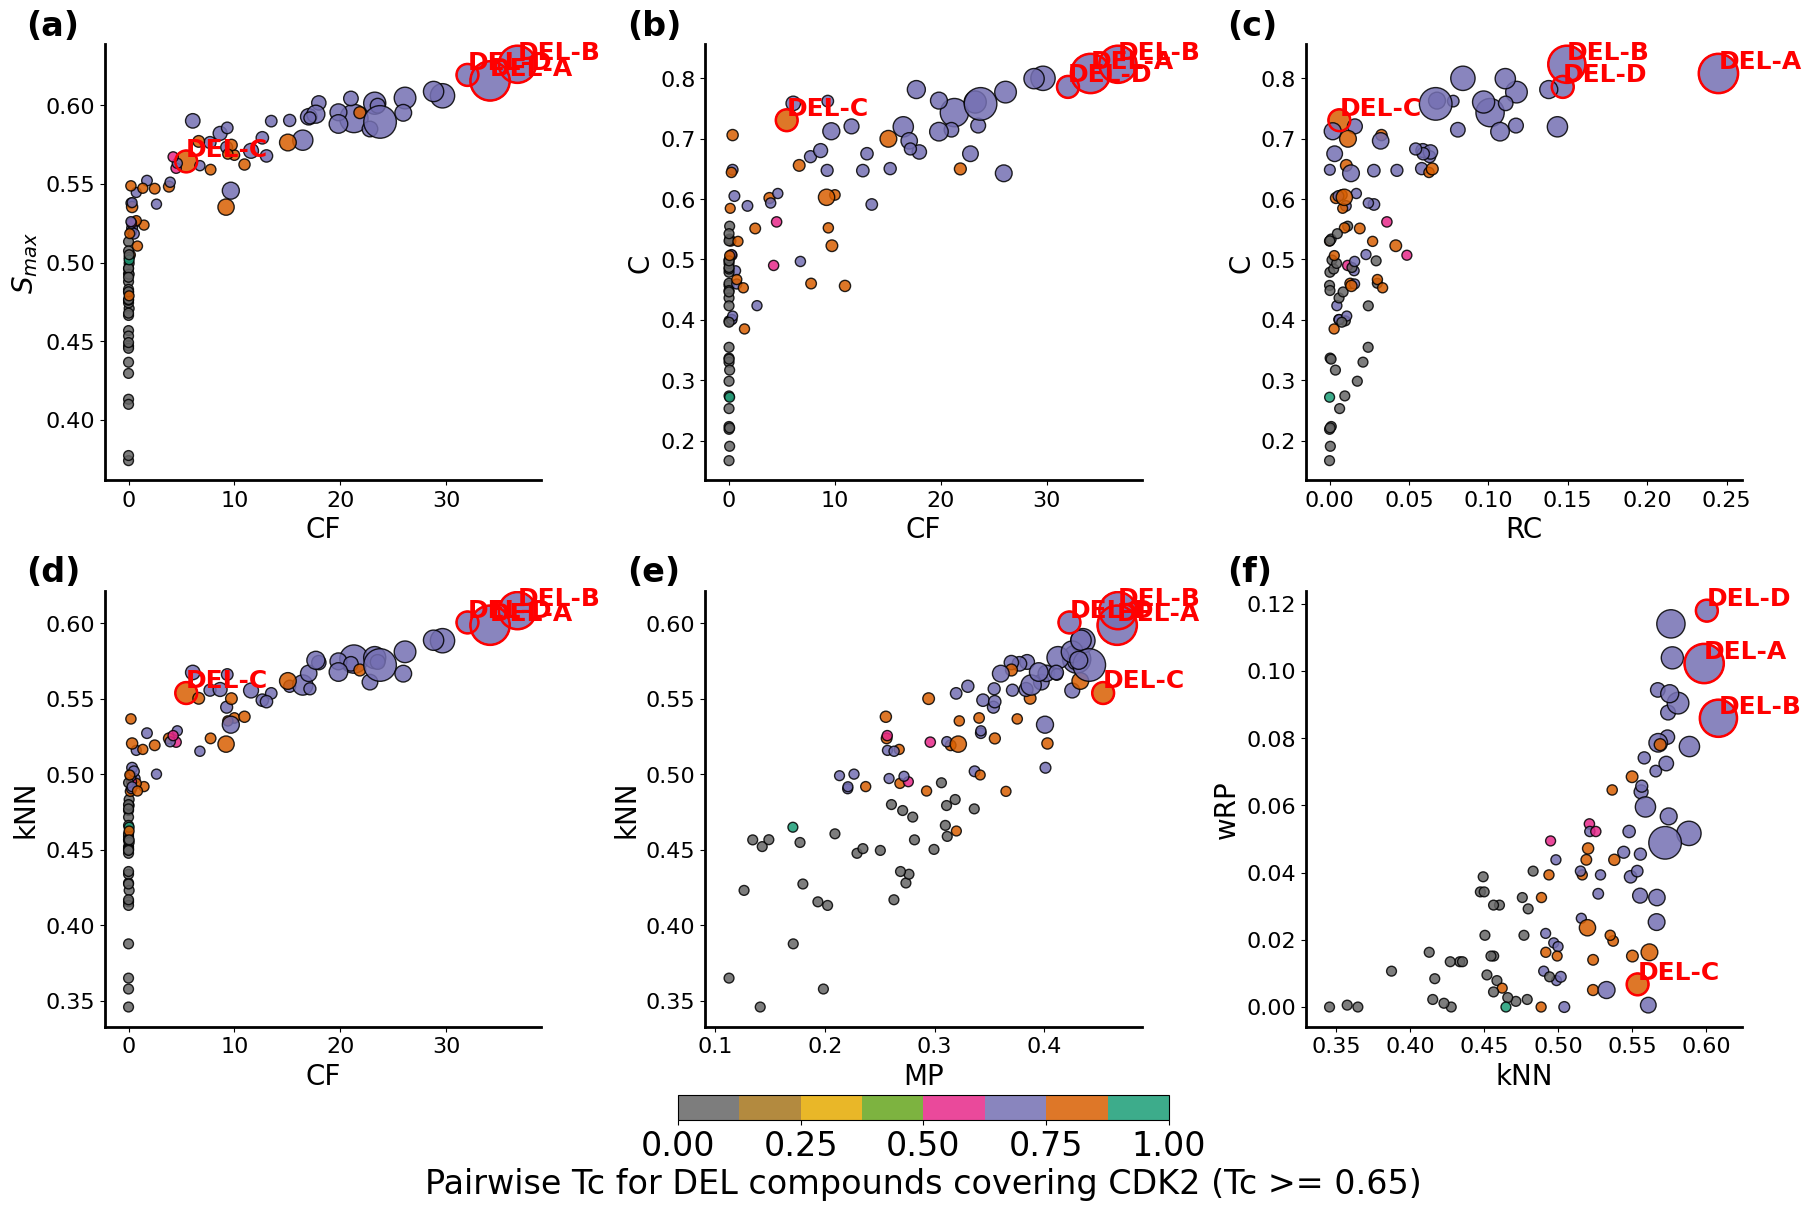

In [15]:
# ---------- build subplots canvas ----------
fig, axs = plt.subplots(
    2, 3, figsize=(18, 12), constrained_layout=True
)

# ---------- helpers for scatters ----------
def scale_sizes(nvals, smin=50, smax=800):
    """Map n_participating values to marker areas (pt^2)."""
    nvals = np.asarray(nvals)
    if np.nanmax(nvals) == np.nanmin(nvals):
        return np.full_like(nvals, (smin + smax) / 2.0, dtype=float)
    return np.interp(nvals, (np.nanmin(nvals), np.nanmax(nvals)), (smin, smax))

def draw_scatter(ax, df, xcol, ycol, x_title, y_title,
                 size_col='n_participating_library_thresh_0.35',
                 color_col='intra_library_similarity_mean_thresh_0.35',
                 labels_to_annotate=None, label_names=None,
                 ylim=None):
    # mask rows with all required values
    mask = df[[xcol, ycol, size_col, color_col]].notna().all(axis=1)
    d = df.loc[mask]

    sizes = scale_sizes(d[size_col].values)  # pt^2
    cvals = d[color_col].values

    sc = ax.scatter(
        d[xcol].values, d[ycol].values,
        s=sizes, c=cvals, cmap='inferno', edgecolor='k', alpha=0.85
    )
    
    ax.set_xlabel(x_title, fontsize=20)
    ax.set_ylabel(y_title, fontsize=20)
    ax.tick_params(labelsize=16)
    for spine in ('top', 'right'):
        ax.spines[spine].set_visible(False)
    for spine in ('left', 'bottom'):
        ax.spines[spine].set_linewidth(2.0)
    if ylim is not None:
        ax.set_ylim(*ylim)

    # annotate requested labels (using index match)
    if labels_to_annotate:
        for lab in labels_to_annotate:
            if lab in d.index:
                xx = d.at[lab, xcol]
                yy = d.at[lab, ycol]
                # highlight ring (fix: index into sizes using d, not df)
                idx = d.index.get_loc(lab)
                ax.scatter([xx], [yy],
                           s=float(sizes[idx]),
                           facecolor='none', edgecolor='red', linewidth=1.8, zorder=3)
                # label text (use custom name if provided)
                try:
                    name = label_names.get(lab, lab) if label_names is not None else lab
                except Exception:
                    name = lab
                ax.text(xx, yy, str(name),
                        fontsize=18, color='red', weight='bold',
                        ha='left', va='bottom')

    return sc, cvals  # return PathCollection + colors for global norm

# ---------- (0,0)–(1,2) Scatters with size+color mapping ----------
labels_to_annotate = ['EN5723_1', 'EN16700_1', 'EN11303_1', 'EN23710_1']
try:
    label_names_dict = custom_names
except NameError:
    label_names_dict = None

# use all six axes (including what used to be the heatmap slot)
scatter_axes = [axs[0,0], axs[0,1], axs[0,2], axs[1,0], axs[1,1], axs[1,2]]
specs = [
    # NEW panel replacing the heatmap:
    ('pct_covered_targets_thresh_0.35', 'sim_tan_mfp_s_min', 'CF', r'$S_{max}$', None),
    ('pct_covered_targets_thresh_0.35', 'sim_tan_mfp_centroid', 'CF', 'C', None),
    ('sim_tan_resp_centroid', 'sim_tan_mfp_centroid', 'RC', 'C', None),
    ('pct_covered_targets_thresh_0.35', 'sim_tan_mfp_knn', 'CF', 'kNN', None),
    ('sim_tan_mean_pairwise', 'sim_tan_mfp_knn', 'MP', 'kNN', None),
    ('sim_tan_mfp_knn', 'tan_resp_wRP_GTM', 'kNN', 'wRP', None),
]

collections = []
all_cvals = []

for ax, (xcol, ycol, xt, yt, ylims) in zip(scatter_axes, specs):
    sc, cvals = draw_scatter(
        ax, fin_df_intra, xcol, ycol, xt, yt,
        labels_to_annotate=labels_to_annotate, label_names=label_names_dict,
        ylim=ylims
    )
    collections.append(sc)
    all_cvals.append(cvals)

# ---------- single, shared color normalization + colorbar ----------
all_cvals = np.concatenate(all_cvals)
vmin, vmax = np.nanmin(all_cvals), 1.0#np.nanmax(all_cvals)
norm = Normalize(vmin=vmin, vmax=vmax)
for sc in collections:
    sc.set_norm(norm)
    #sc.set_cmap('inferno')
    sc.set_cmap('Dark2_r')

# One shared colorbar for all scatter axes
cbar = fig.colorbar(collections[0], ax=scatter_axes, location="bottom", fraction=0.025, pad=0.005)
cbar.set_label('Pairwise Tc for DEL compounds covering CDK2 (Tc >= 0.65)', fontsize=24)
cbar.ax.tick_params(labelsize=24)
# Shared norm for every scatter


# ---------- panel labels ----------
labels = list("abcdef")  # a–f for the 6 panels
axes_in_order = scatter_axes
for lab, ax in zip(labels, axes_in_order):
    ax.text(-0.18, 1.08, f"({lab})",
            transform=ax.transAxes, ha="left", va="top",
            fontsize=24, fontweight="bold",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.0))

def pad_xlim(ax, pct=0.01):
    xmin, xmax = ax.get_xlim()
    r = xmax - xmin
    ax.set_xlim(xmin - pct*r, xmax + pct*r)

for ax in axes_in_order:
    pad_xlim(ax, pct=0.01)

# Save & show
plt.savefig("../results/SF3.svg")
plt.show()


---